# Entrenamiento en X  Y Z


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


import sys
sys.path.append('../')
from Utils import plotter as plots
from Utils import geo_conversions as gc

In [3]:
# Obtención, drop y normalización de los datos.
x_test		= pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train		= pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test		= pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train		= pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")

x_train 	= x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test		= x_test.drop(columns =['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

R0 = 6.371E6 #[m]
y_train_xyz = y_train/R0
y_test_xyz	= y_test/R0

In [4]:
# Escalado.
scaler_x	= MinMaxScaler()
scaler_y	= MinMaxScaler()
scaler_z	= MinMaxScaler()

y_train_x_scaled	= scaler_x.fit_transform(y_train_xyz.iloc[:,   :100])
y_train_y_scaled	= scaler_y.fit_transform(y_train_xyz.iloc[:,100:200])
y_train_z_scaled	= scaler_z.fit_transform(y_train_xyz.iloc[:,200:300])

y_test_x_scaled	= scaler_x.transform(y_test_xyz.iloc[:,		:100])
y_test_y_scaled	= scaler_y.transform(y_test_xyz.iloc[:,100:200])
y_test_z_scaled	= scaler_z.transform(y_test_xyz.iloc[:,200:300])



In [5]:
# Callbacks.
reduce_lr		= ReduceLROnPlateau(
	monitor		= 'val_loss',
  patience	= 20,
  factor		= 0.5
)

In [114]:
# definiciones Previas.
act_name	= 'relu'
l2_reg		= 0.0007
epochs		= 1400
b_s				= 32
optimizer = Adam(learning_rate=0.001)

# Arquitectura.
inputs	= Input(shape=(5,))
encoded	= Dense(32,	 activation	= act_name, kernel_regularizer = l2(l2_reg))(inputs)
encoded = Dense(128, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(256, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(512, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(512, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(600, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)

decoded_x = Dense(100, activation = 'linear', name = 'x')(encoded)
decoded_y = Dense(100, activation = 'linear', name = 'y')(encoded)
decoded_z = Dense(100, activation = 'linear', name = 'z')(encoded)

# Definición modelo con multiples salidas.
model_xyz = Model(inputs	= inputs, outputs=[decoded_x, decoded_y, decoded_z])
model_xyz.compile(optimizer = optimizer, loss = 'mse')
model_xyz.summary()

# Entrenamiento.
history_xyz = model_xyz.fit(x_train,
                            [y_train_x_scaled,
                            y_train_y_scaled,
                            y_train_z_scaled],
                            epochs						= epochs,
														batch_size				= b_s,
                            validation_split	= 0.1,
                            callbacks					= [reduce_lr],
                          	)



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 32)        │        192 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 128)       │      4,224 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 256)       │     33,024 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 512)       │    131,584 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 512)       │    262,656 │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 600)       │    307,800 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x (Dense)           │ (None, 100)       │     60,100 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y (Dense)           │ (None, 100)       │     60,100 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Dense)           │ (None, 100)       │     60,100 │ dense_45[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 919,780 (3.51 MB)

 Trainable params: 919,780 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1400
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 79.9929 - x_loss: 20.9608 - y_loss: 29.7440 - z_loss: 28.5198 - val_loss: 0.5219 - val_x_loss: 0.0223 - val_y_loss: 0.0326 - val_z_loss: 0.0297 - learning_rate: 0.0010
Epoch 2/1400
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4931 - x_loss: 0.0167 - y_loss: 0.0224 - z_loss: 0.0249 - val_loss: 0.4544 - val_x_loss: 0.0104 - val_y_loss: 0.0132 - val_z_loss: 0.0159 - learning_rate: 0.0010
Epoch 3/1400
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4572 - x_loss: 0.0121 - y_loss: 0.0144 - z_loss: 0.0187 - val_loss: 0.4663 - val_x_loss: 0.0183 - val_y_loss: 0.0148 - val_z_loss: 0.0278 - learning_rate: 0.0010
Epoch 4/1400
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4492 - x_loss: 0.0130 - y_loss: 0.0135 - z_loss: 0.0193 - val_loss: 0.4373 - val_x_loss: 0.0111 - val_y_loss: 0.0112 - val_z_loss: 0.0169 - learning_rate: 0.0010
Epoch 5/1400
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4385 - x_loss: 0.0111 - y_lo

In [115]:
loss = model_xyz.evaluate(x_test,[y_test_x_scaled,
																	y_test_y_scaled,
																	y_test_z_scaled],
													)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - x_loss: 0.0013 - y_loss: 0.0015 - z_loss: 0.0017            


In [120]:
idx = 78 # 78-521-545-578
pred_x_scaled, pred_y_scaled, pred_z_scaled = model_xyz.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
pred_x = scaler_x.inverse_transform(pred_x_scaled).flatten()
pred_y = scaler_y.inverse_transform(pred_y_scaled).flatten()
pred_z = scaler_z.inverse_transform(pred_z_scaled).flatten()
true_x = y_test_xyz.iloc[idx,	 	 :100].to_numpy()
true_y = y_test_xyz.iloc[idx,	100:200].to_numpy()
true_z = y_test_xyz.iloc[idx, 200:300].to_numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [121]:
# plots.plot_1D(true_x, pred_x,'x')
# plots.plot_1D(true_y, pred_y,'y')
# plots.plot_1D(true_z, pred_z,'z')
# plots.plot_2D(true_x, true_y, pred_x, pred_y)

In [122]:
lat_true, lon_true, alt_true = gc.transform_spherical_to_geographic(*gc.transform_cartesian_to_spherical(true_x, true_y, true_z))
lat_pred, lon_pred, alt_pred = gc.transform_spherical_to_geographic(*gc.transform_cartesian_to_spherical(pred_x, pred_y, pred_z))

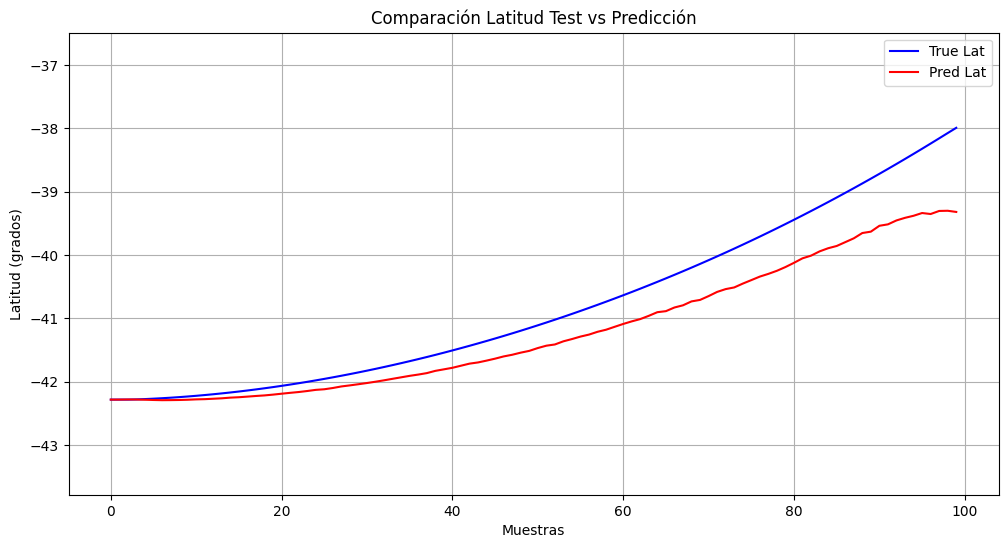

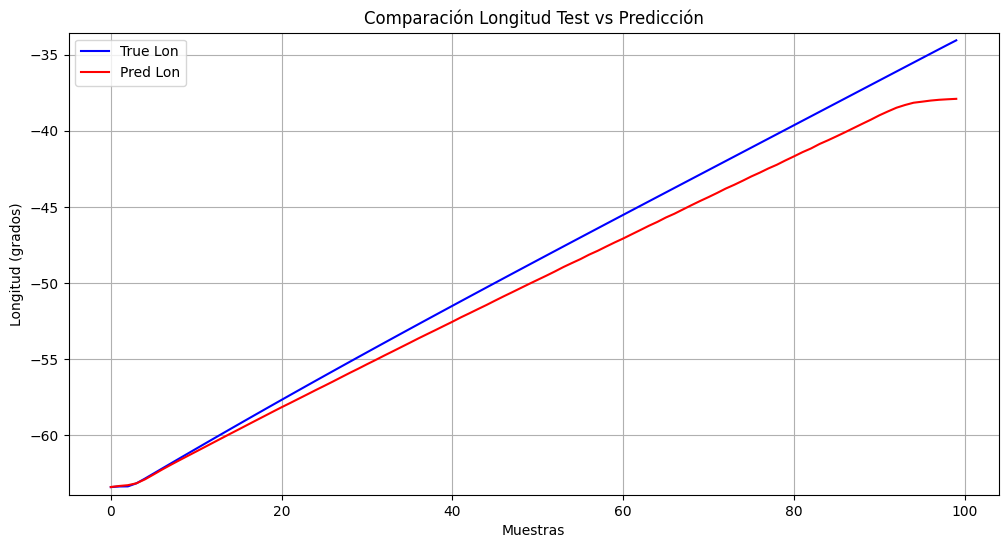

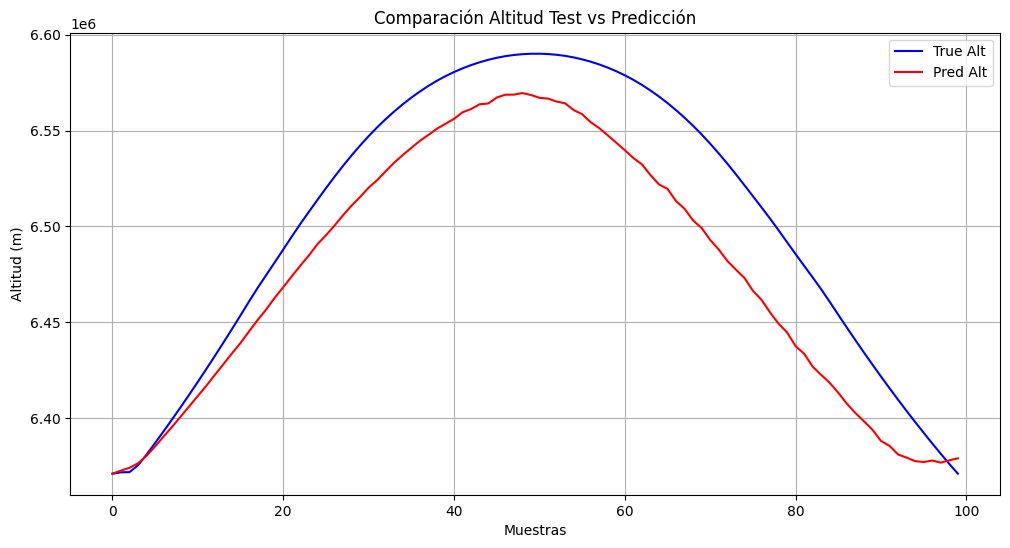

In [123]:
plt.figure(figsize = (12,6))
plt.plot(lat_true, label = 'True Lat', color = 'blue')
plt.plot(lat_pred, label = 'Pred Lat', color = 'red')
plt.ylim(lat_true.min() - 1.5, lat_true.max() + 1.5)
plt.title('Comparación Latitud Test vs Predicción')
plt.ylabel('Latitud (grados)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize= (12,6))
plt.plot(lon_true, label = 'True Lon', color = 'blue')
plt.plot(lon_pred, label = 'Pred Lon', color = 'red')
plt.ylim(lon_true.min() - 0.5, lon_true.max() + 0.5)
plt.title('Comparación Longitud Test vs Predicción')
plt.ylabel('Longitud (grados)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (12,6))
plt.plot(alt_true*R0, label = 'True Alt', color = 'blue')
plt.plot(alt_pred*R0, label = 'Pred Alt', color = 'red')
plt.title('Comparación Altitud Test vs Predicción')
plt.ylabel('Altitud (m)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()


In [124]:
import pickle

save_model = True

if save_model:
    model_xyz.save('../modelos_entrenamiento/mod_x_y_z_R0/modelo3/modelo_xyz.keras')

    with open('../modelos_entrenamiento/mod_x_y_z_R0/modelo3/scaler_x.pkl', 'wb') as file:
        pickle.dump(scaler_x, file)

    with open('../modelos_entrenamiento/mod_x_y_z_R0/modelo3/scaler_y.pkl', 'wb') as file:
        pickle.dump(scaler_y, file)

    with open('../modelos_entrenamiento/mod_x_y_z_R0/modelo3/scaler_z.pkl', 'wb') as file:
        pickle.dump(scaler_z, file)
